In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
sns.set()

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load data
with np.load('cifar4-train.npz', allow_pickle=False) as data:
    X = data['overfeat']
    y = data['labels']
    
print(X.shape)
print(y.shape)

(5000, 4096)
(5000,)


In [3]:
# split to train, validation, test
from sklearn.model_selection import train_test_split

X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, stratify=y,
        test_size=1000, random_state=0
        )

X_tr, X_val, y_tr, y_val = train_test_split(
        X_tr, y_tr, stratify=y_tr,
        test_size=800, random_state=0
        )

print(X_tr.shape)
print(X_val.shape)
print(X_te.shape)

(3200, 4096)
(800, 4096)
(1000, 4096)


In [4]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle indices
    shuffled_idx = np.arange(len(y))
    np.random.shuffle(shuffled_idx)
    
    for i in range(0, len(y), batch_size):
        batch_idx = shuffled_idx[i: i+batch_size]
        yield X[batch_idx], y[batch_idx]

# Define Network

In [5]:
# I set my graph
graph = tf.Graph()

with graph.as_default():
    # create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 4096])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    # create training placeholder for dropout
    training = tf.placeholder(dtype=tf.bool)
    
    # apply dropout to input layer
    X_drop = tf.layers.dropout(
        X, rate=0.5, seed=0, training=training)
    
    # hidden layer with 64 units
    hidden = tf.layers.dense(
        X_drop, 64, activation=tf.nn.relu,
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden')
    
    # apply dropout to hidden layer
    hidden = tf.layers.dropout(
        hidden, rate=0.5, seed=0, training=training)
    
    # 4 logits
    logits = tf.layers.dense(
        hidden, 4, activation=None,
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output')

In [6]:
# Define loss function and training operations
with graph.as_default():
    
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel') # weights of hidden layer
        
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel') # weights of output layer
    
    # loss: mean_cross_entropy
    mean_ce = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                    labels=y, logits=logits
                    )
            )
    
    # L2 norm of weights
    L2_term_W1 = tf.nn.l2_loss(W1)
    L2_term_W2 = tf.nn.l2_loss(W2)
    
    # alpha parameter
    alpha = tf.placeholder(dtype=tf.float32)
    
    # regularized cross-entropy
    loss = mean_ce + alpha * (L2_term_W1 + L2_term_W2)
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)
    
    # minimize cross-entropy with regularization
    train_op = gd.minimize(loss)
    
    # compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

# Train network

In [7]:
# TRAIN NETWORK
num_epochs = 300
learning_rate = 0.001
reg_term = 0.01
num_batches = 32

valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # initialize variables
    sess.run(tf.global_variables_initializer())
    
    # set seed
    np.random.seed(0)
    
    # train several epochs
    for epoch in range(num_epochs):
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_tr, y_tr, num_batches):
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: learning_rate,
                training: True,
                alpha: reg_term
                })
    
        batch_acc.append(acc_value)
        
        # evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
                X: X_val,
                y: y_val,
                training: False
                })
        valid_acc_values.append(valid_acc)
    
        # print progress every 10 epochs
        if np.mod(epoch,10) == 0:
            print('Epoch {} - valid: {:.3f} train {:.3f} (mean)'.format(
                    epoch+1, valid_acc, np.mean(batch_acc)
                    )
                )
    
    # evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={
            X: X_te,
            y: y_te,
            training: False
            })

Epoch 1 - valid: 0.529 train 0.406 (mean)
Epoch 11 - valid: 0.752 train 0.562 (mean)
Epoch 21 - valid: 0.784 train 0.688 (mean)
Epoch 31 - valid: 0.808 train 0.562 (mean)
Epoch 41 - valid: 0.806 train 0.562 (mean)
Epoch 51 - valid: 0.814 train 0.781 (mean)
Epoch 61 - valid: 0.819 train 0.875 (mean)
Epoch 71 - valid: 0.817 train 0.781 (mean)
Epoch 81 - valid: 0.831 train 0.656 (mean)
Epoch 91 - valid: 0.834 train 0.781 (mean)
Epoch 101 - valid: 0.824 train 0.844 (mean)
Epoch 111 - valid: 0.832 train 0.844 (mean)
Epoch 121 - valid: 0.826 train 0.750 (mean)
Epoch 131 - valid: 0.834 train 0.781 (mean)
Epoch 141 - valid: 0.830 train 0.875 (mean)
Epoch 151 - valid: 0.831 train 0.688 (mean)
Epoch 161 - valid: 0.845 train 0.875 (mean)
Epoch 171 - valid: 0.835 train 0.844 (mean)
Epoch 181 - valid: 0.835 train 0.906 (mean)
Epoch 191 - valid: 0.842 train 0.844 (mean)
Epoch 201 - valid: 0.835 train 0.750 (mean)
Epoch 211 - valid: 0.836 train 0.750 (mean)
Epoch 221 - valid: 0.836 train 0.812 (mean)

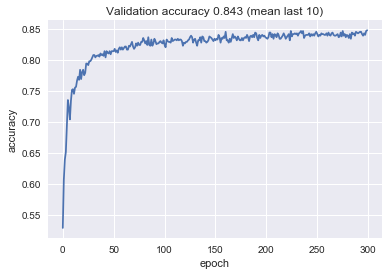

In [8]:
# plot validation accuracy after each epoch
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 10)'.format(
        np.mean(valid_acc_values[-10:])
        ))
    
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [9]:
print('Multilayer fully-connected network accuracy ',
      '(test set): {:.4f}'.format(test_acc))

Multilayer fully-connected network accuracy  (test set): 0.8300
